In [1]:
import pandas as pd
import numpy as np

## Data Preprocess

In [2]:
train = pd.read_csv("train.csv",dtype = {'Upc': str, 'FinelineNumber':str, 'TripType':"category" , 'Weekday':"category"})
test = pd.read_csv("test.csv",dtype = {'Upc': str, 'FinelineNumber':str, 'TripType':"category" , 'Weekday':"category"})

In [3]:
dat = pd.concat([train,test])#1300700 rows × 7 columns
dat.reset_index(inplace=True,drop=True)

In [4]:
dat.drop(['TripType', 'Upc'], axis = 1,inplace = True)

### Missing value

In [5]:
#Deal with missing value in Dept with replacement of "dept_other"
dept_missing_index = list(dat[dat['DepartmentDescription'].isnull()].index)
for i in dept_missing_index:
    dat["DepartmentDescription"].iloc[i] = "dept_other"

/Users/michellehsu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
#Deal with missing value in FinelineNumber with replacement of "fn_other"
fn_missing_index = list(dat[dat['FinelineNumber'].isnull()].index)
for i in fn_missing_index:
    dat['FinelineNumber'].iloc[i] = "fn_other"

/Users/michellehsu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
dat.head() #1300700 rows × 5 columns

,DepartmentDescription,FinelineNumber,ScanCount,VisitNumber,Weekday
0,FINANCIAL SERVICES,1000,-1,5,Friday
1,SHOES,8931,1,7,Friday
2,PERSONAL CARE,4504,1,7,Friday
3,PAINT AND ACCESSORIES,3565,2,8,Friday
4,PAINT AND ACCESSORIES,1017,2,8,Friday


### Feature Engineering

#### 1. Spread the FinelineNumber as feature

In [8]:
dat['FinelineNumber_copy'] = dat['FinelineNumber']

In [9]:
group_visit_fineline = dat.groupby(['VisitNumber','FinelineNumber'],as_index=False).agg({'FinelineNumber_copy':'count'})

In [10]:
dictVector = []
visitnum = group_visit_fineline['VisitNumber'][1]
visitdict = {}
for i in range(len(group_visit_fineline)):
    if(group_visit_fineline['VisitNumber'][i] == visitnum):
        visitdict[group_visit_fineline['FinelineNumber'][i]] = group_visit_fineline['FinelineNumber_copy'][i]
    else:
        dictVector.append(visitdict)
        visitdict = {}
        visitdict[group_visit_fineline['FinelineNumber'][i]] = group_visit_fineline['FinelineNumber_copy'][i]
        visitnum = group_visit_fineline['VisitNumber'][i]
# Append the last one
dictVector.append(visitdict)

In [11]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)

In [12]:
X = v.fit_transform(dictVector)

#### 2. Spread the Weekday as feature

In [13]:
day = pd.get_dummies(dat[["VisitNumber", "Weekday"]], columns = ["Weekday"])
day = day.drop_duplicates()

# Find unique VisitNumber
uids = group_visit_fineline['VisitNumber'].unique()

# Keep VisitNumber in uids
day = day[day['VisitNumber'].isin(uids)]

In [14]:
day.sort_values(['VisitNumber'], inplace=True)

In [15]:
new_X = np.concatenate((X, day), axis=1) #(191348, 5362)

#### 3. Spread the DepartmentDescription as feature

In [16]:
dept = dat.groupby(['VisitNumber','DepartmentDescription']).agg({'DepartmentDescription':'count'})

In [17]:
dept = dept.unstack()

In [18]:
dept = dept['DepartmentDescription']

In [19]:
dept.fillna(0, inplace= True)

In [20]:
dp = []
for i in uids:
    dp.append(list(dept.loc[i]))

In [21]:
department = np.array(dp) #(191348, 69)
department[department > 0] = 1

In [22]:
final = np.concatenate((new_X, department), axis=1) #(191348, 5431)

#### Randomly subseting 15000 samples to work through the pipeline

In [23]:
subset = []
for i in np.random.randint(len(final), size = 15000):
    subset.append(final[i])
subset = np.array(subset)

## Dimension Reduction

### PCA

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [25]:
scaler = StandardScaler()
subset_normalized = scaler.fit_transform(subset) 

In [26]:
pca = PCA(1)
pca.fit(subset_normalized)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [27]:
pca.explained_variance_ratio_ 

array([ 0.00361054])

### t-SNE 

In [28]:
from sklearn.manifold import TSNE

In [29]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40) 
tsne_2d = tsne.fit_transform(subset_normalized)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15000 samples in 5.189s...
[t-SNE] Computed neighbors for 15000 samples in 1596.843s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')  

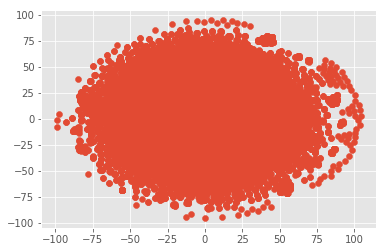

In [31]:
plt.scatter(tsne_2d[:, 0], tsne_2d[:, 1])
plt.show()

## Clustering

### GaussianMixture

In [32]:
from sklearn.mixture import GaussianMixture

In [33]:
gmm = GaussianMixture(n_components=5, n_init=100)
gmm.fit(tsne_2d)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=100, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [34]:
gmm_cluster_assignments = gmm.predict(tsne_2d)

In [36]:
gmm_cluster_assignments.shape #(15000,)
gmm_cluster_assignments = gmm_cluster_assignments.reshape((15000, 1))

In [37]:
# Append assignment into original data set
labeled = np.concatenate((subset, gmm_cluster_assignments), axis=1) #(15000, 5432)

## Classification

### Model 1: Random Forest

In [38]:
y = labeled[:,-1]
X = labeled[:, 0:5431]

In [39]:
# Split data into train and test
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

/Users/michellehsu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [41]:
# Preparation for tuning the parameters of random forest
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(10, 110, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 10)]
max_depth.append(None)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=1, n_jobs = -1)
# Fit train data to random forest
rf_random.fit(X_train, y_train)
# Predict test data 
pred_rf = rf_random.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.9min finished


In [42]:
rf_random.best_params_

{'max_depth': None, 'n_estimators': 43}

In [43]:
# Evaluate the random forest model 
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm_rf = confusion_matrix(y_test, pred_rf)
#Calculate test error
1-(sum(cm_rf.diagonal())/cm_rf.sum())

0.42066666666666663

### Model 2: Adaboost

In [44]:
from sklearn.ensemble import AdaBoostClassifier

In [45]:
# Fit train data to Adaboost
ab = AdaBoostClassifier(learning_rate=1, n_estimators= 110)
ab.fit(X_train, y_train)
# Predict test data 
pred_ab = ab.predict(X_test)

In [46]:
# Evaluate the Adaboost model
cm_ab = confusion_matrix(y_test, pred_ab)
#Calculate test error
1-(sum(cm_ab.diagonal())/cm_ab.sum())

0.51866666666666661